In [1]:
import navis
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_color_codes('muted')

In [6]:
# Load a single skeleton (i.e. a TreeNeuron)
n = navis.example_neurons(n=1, kind='skeleton')
n.cable_length

266476.88

In [91]:
print((n.cable_length * n.units).to('microns'))

2131.815 micron


In [20]:
# Load a couple skeletons
nl = navis.example_neurons(kind='skeleton')
print(nl.cable_length)

[266476.88 304332.66 274703.38 286522.47 291265.3 ]


In [92]:
print(nl.n_branches)

[599 735 633 696 626]


In [3]:
df = nl.summary()
df.head()

,type,name,id,n_nodes,n_connectors,n_branches,n_leafs,cable_length,soma,units
0,navis.TreeNeuron,1734350788,1734350788,4465,2705,599,618,266476.87500,[4177],8 nanometer
1,navis.TreeNeuron,1734350908,1734350908,4847,3042,735,761,304332.65625,[6],8 nanometer
2,navis.TreeNeuron,722817260,722817260,4332,3136,633,656,274703.37500,None,8 nanometer
3,navis.TreeNeuron,754534424,754534424,4696,3010,696,726,286522.46875,[4],8 nanometer
4,navis.TreeNeuron,754538881,754538881,4881,2943,626,642,291265.31250,[701],8 nanometer


In [2]:
# Load a single MeshNeuron
m = navis.example_neurons(n=1, kind='mesh')
print(m.volume)

1291610825.1668377


In [3]:
print(m.skeleton.cable_length)

168890.5891599271


In [4]:
m.skeleton.n_leafs

155

In [5]:
m.skeleton.n_branches

122

In [7]:
m.n_vertices

6309

In [8]:
m.skeleton.n_nodes

1058

In [9]:
# Illustrate with a random property
m.my_counts = [1, 2, 3, 4, 5]
m.n_my_counts

5

In [10]:
sa = navis.segment_analysis(m)
sa.head()

,length,tortuosity,root_dist,strahler_index,radius_mean,radius_min,radius_max,volume
0,84.610286,1.320717,7083.656132,1,61.481414,11.867318,148.842288,1.420165e+06
1,276.524917,2.589908,41381.328436,1,58.348518,3.699802,165.413996,6.111648e+06
2,141.448954,1.079153,12560.860744,1,86.103133,24.133240,156.117439,4.873987e+06
3,59.935134,1.122367,11144.594281,1,32.241229,3.699802,85.624280,4.333826e+05
4,141.513383,1.362527,38527.170130,1,44.703457,9.421692,139.731548,1.472218e+06


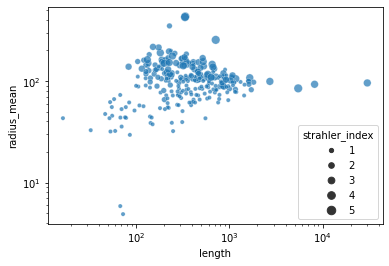

In [18]:
# See if segment length correlates with radius
ax = sns.scatterplot(data=sa, x='length', y='radius_mean', size='strahler_index', alpha=.7)
ax.set_xscale('log')
ax.set_yscale('log')

In [22]:
import numpy as np

# Get nodes but remove the root (has no parent)
nodes = nl[0].nodes[nl[0].nodes.parent_id > 0]

# Get the x/y/z coordinates of all nodes (except root)
node_locs = nodes[['x', 'y', 'z']].values

# For each node, get its parent's location
parent_locs = nl[0].nodes.set_index('node_id').loc[nodes.parent_id.values, ['x', 'y', 'z']].values

# Calculate Euclidian distances
distances = np.sqrt(np.sum((node_locs - parent_locs)**2, axis=1))

# Use the neuron's units to convert into nm 
distances = distances * nl[0].units

print(f'Mean distance between nodes: {np.mean(distances):.2f} (+/- {np.std(distances):.2f})')

Mean distance between nodes: 477.56 nanometer (+/- 361.10 nanometer)


In [23]:
n = nl[0]

end = n.nodes[n.nodes.type == 'end'].node_id.values[0]

d_geo = navis.dist_between(n, n.soma, end) * n.units

print(f'Euclidean distance between soma and terminal node {end}: {d_geo:.2f}')

Euclidean distance between soma and terminal node 465: 444096.17 nanometer


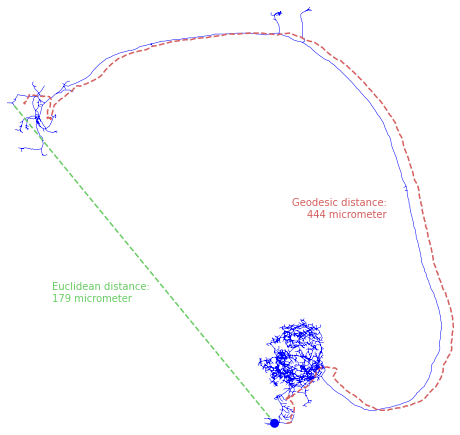

In [24]:
import networkx as nx

# First we need to find the path between the soma and the terminal node
path = nx.shortest_path(n.graph.to_undirected(), n.soma[0], end)

# Get coordinates for the path
path_co = n.nodes.set_index('node_id').loc[path, ['x', 'y', 'z']].copy()

# Add a small offset
path_co.x += 500
path_co.y -= 500

# Plot neuron
fig, ax = navis.plot2d(n, c='blue', method='2d', view=('x', '-z'))

# Add geodesic path
ax.plot(path_co.x, -path_co.z, c='r', ls='--')

# Add Euclidian path
end_loc = n.nodes.set_index('node_id').loc[end, ['x', 'y', 'z']]
soma_loc = n.nodes.set_index('node_id').loc[n.soma[0], ['x', 'y', 'z']]
ax.plot([soma_loc.x, end_loc.x], [-soma_loc.z, -end_loc.z], c='g', ls='--')

d_eucl = np.sqrt(np.sum((end_loc - soma_loc)**2)) * n.units

# Annotate distances
_ = ax.text(x=0.1, y=.3, s=f'Euclidean distance:\n{d_eucl.to_compact():.0f}', transform=ax.transAxes, c='g')
_ = ax.text(x=.85, y=.5, s=f'Geodesic distance:\n{d_geo.to_compact():.0f}', transform=ax.transAxes, c='r', ha='right')

plt.show()

In [87]:
# Calculate distances from all end nodes to all other nodes
ends = n.nodes[n.nodes.type=='end'].node_id.values
m = navis.geodesic_matrix(n, from_=ends)

# Subset to only end-nodes-to-end_nodes
m = m.loc[ends, ends]

m.head()

,465,548,618,683,745,789,832,872,911,949,...,4456,4457,4458,4459,4460,4461,4462,4463,4464,4465
465,0.000000,54395.706752,53556.405732,54489.728022,53685.768456,52679.982779,53139.882271,20944.502247,53065.272557,53873.631365,...,50402.960991,50363.976517,49936.090104,49895.070897,55185.275744,54742.764466,55158.505486,55950.521492,56111.790505,55266.165581
548,54395.706752,0.000000,8980.969668,10787.026090,6228.693973,6866.540223,8564.446208,37619.898765,8489.836493,6416.556882,...,4589.518435,5788.540454,5360.654040,5319.634833,12127.772206,11685.260928,12101.001948,12893.017955,13054.286967,12208.662044
618,53556.405732,8980.969668,0.000000,9947.725069,8271.031372,7265.245695,4698.465309,36780.597744,3951.850620,8458.894281,...,4988.223907,4060.795593,3828.188293,3866.356197,11288.471186,10845.959908,11261.700928,12053.716934,12214.985947,11369.361023
683,54489.728022,10787.026090,9947.725069,0.000000,10077.087793,9071.302116,9531.201609,37713.920034,9456.591894,10264.950703,...,6794.280329,6755.295855,6327.409441,6286.390234,12221.793476,11779.282198,12195.023218,12987.039225,13148.308237,12302.683313
745,53685.768456,6228.693973,8271.031372,10077.087793,0.000000,6156.601927,7854.507912,36909.960468,7779.898197,4485.482889,...,3879.580139,5078.602158,4650.715744,4609.696537,11417.833910,10975.322632,11391.063652,12183.079659,12344.348671,11498.723747


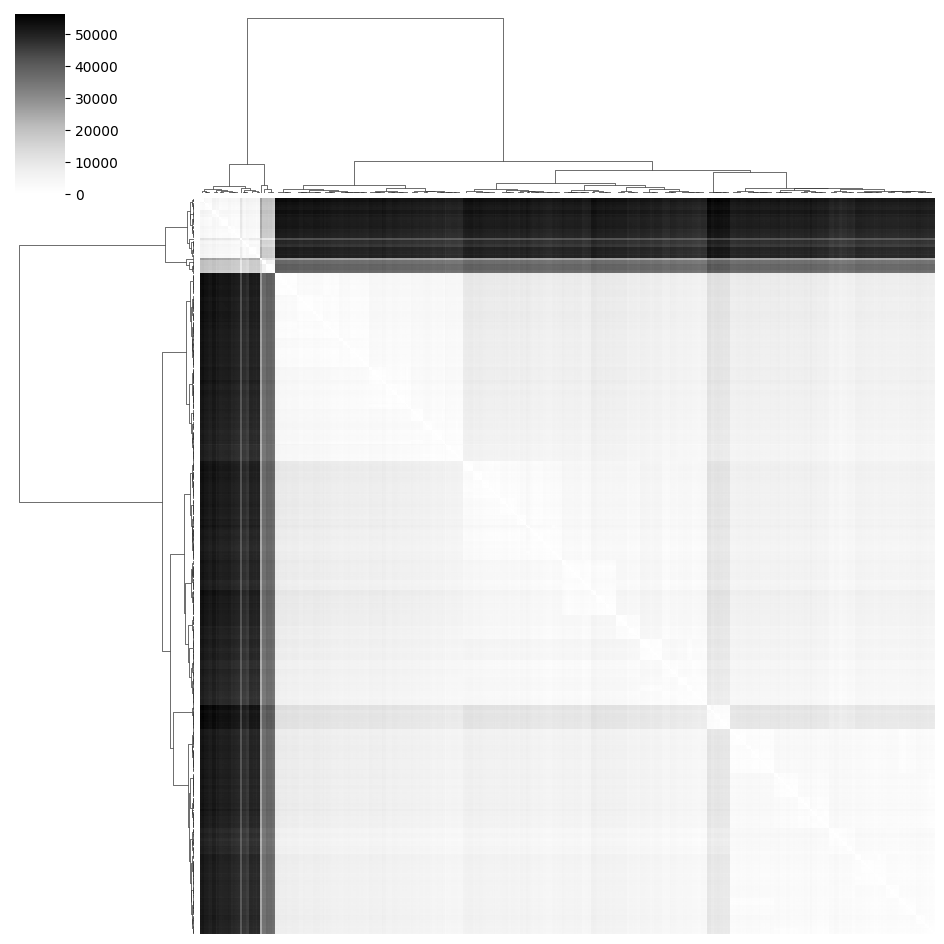

In [97]:
import seaborn as sns

from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

# Generate a linkage from the distances
Z = linkage(squareform(m, checks=False), method='ward')

# Plot
cm = sns.clustermap(m, cmap='Greys', col_linkage=Z, row_linkage=Z)

cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_yticks([])

plt.show()